In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from core.util.plot_predictions import plot_predictions
from core.util.get_datasets import cross_validation
from core.util.trefor_dataset import TreforData
from core.models import LSTM
from core.models.model_training import train_model, test_model
from core.util.hyperparameter_configuration import get_hyperparameter_configuration
from core.util.early_stop import EarlyStop

Set global parameters.

In [2]:
# To be modified depending on gridsearch result
batch_size = 128
learning_rate = 0.001
num_layers = 1
lookback = 36

# Extract hyperparameters configuration that will not be tuned upon
hidden_size, EPOCHS, horizon, lookback, loss_function, dropout_rate, folds = (
    get_hyperparameter_configuration()
)

Use CUDA (GPU) if available.

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

Initialize a very basic LSTM.

In [4]:
def get_model() -> nn.Module:
    """Get the model for training folds."""
    model = LSTM(
        input_size=1,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout_rate=dropout_rate,
        horizon=horizon,
        lookback=lookback,
    )
    model.to(device)
    return model

Validate the training model on the validation set for each epoch.

In [5]:
best_fold_loss = float("inf")
best_fold_model = None
best_prediction = None
best_train_loss = None
best_val_loss = None
best_fold = 0

y_test_global = None

for i, (x_train, y_train, x_val, y_val, x_test, y_test, indicies) in enumerate(
    cross_validation(lookback=lookback, horizon=horizon, folds=folds)
):
    model = get_model()
    # convert to dataset that can use dataloaders
    train_dataset = TreforData(x_train, y_train, device)
    val_dataset = TreforData(x_val, y_val, device)
    test_dataset = TreforData(x_test, y_test, device)

    # initialize the dataloaders, without shuffeling the data between epochs
    training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    testing_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # train the model using this specific fold
    plot_train_loss, plot_val_loss, best_model = train_model(
        epochs=EPOCHS,
        model=model,
        loss_function=loss_function,
        training_loader=training_loader,
        validation_loader=validation_loader,
        learning_rate=learning_rate,
        early_stopper=EarlyStop(5, 0.05),
    )

    # run on test set
    t_loss, predicted = test_model(
        best_model=best_model,
        loss_function=loss_function,
        testing_loader=testing_loader,
    )

    # ugly way to save the y_test which is always the same
    if i == 0:
        y_test_global = y_test

    if t_loss < best_fold_loss:
        best_fold_loss = t_loss
        best_fold_model = best_model
        best_prediction = predicted
        best_train_loss = plot_train_loss
        best_val_loss = plot_val_loss
        best_fold = i

    print(f"Avg loss: {t_loss:>8f} \n")

print(f"Best fold: {best_fold}")
print(f"Loss: {best_fold_loss}")

Iterating epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Avg loss: 0.076597 



Iterating epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Avg loss: 0.066926 



Iterating epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Avg loss: 0.065879 



Iterating epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Avg loss: 0.078716 



Iterating epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Avg loss: 0.083172 

Best fold: 2
Loss: 0.0658787818157292


## Visualize model performance
Visualize the training and validation loss.

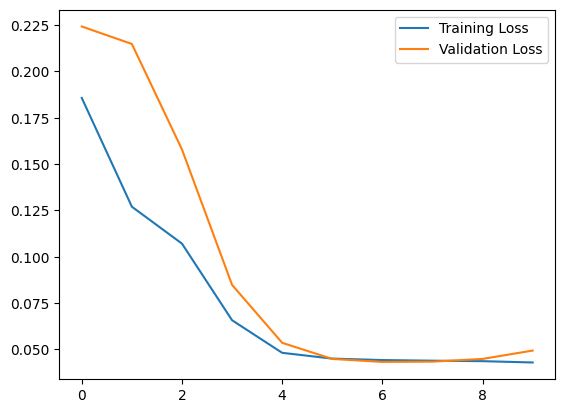

In [6]:
plt.clf()
plt.plot(best_train_loss, label="Training Loss")
plt.plot(best_val_loss, label="Validation Loss")
plt.legend()
plt.show()

Plot the actual values and predictions from the model on the validation set.

Plot predictions for the first 7 days in the validation set

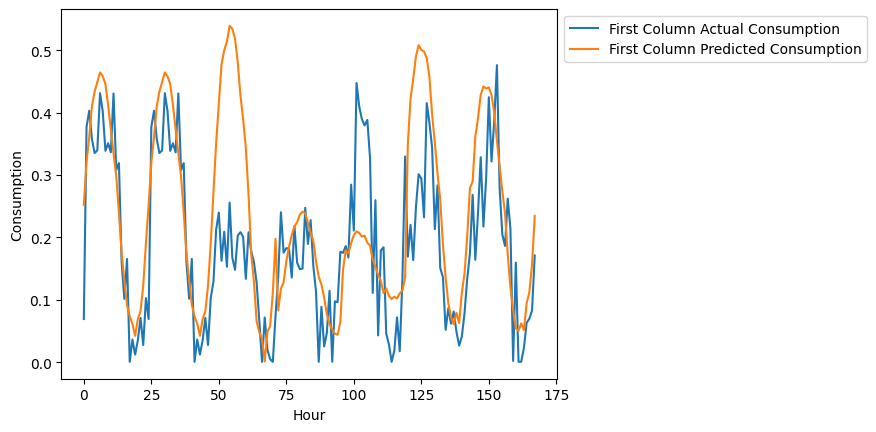

In [7]:
plot_predictions(0, 6, y_test, best_prediction)

Plot predictions for the last 7 days in the validation set

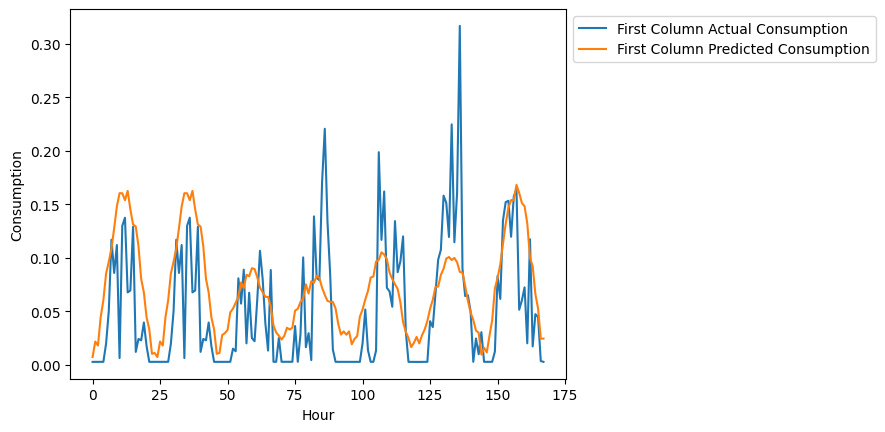

In [8]:
plot_predictions(-7, -1, y_test, best_prediction)

Plot predictions for 7 days in the in the middle of the validation set.

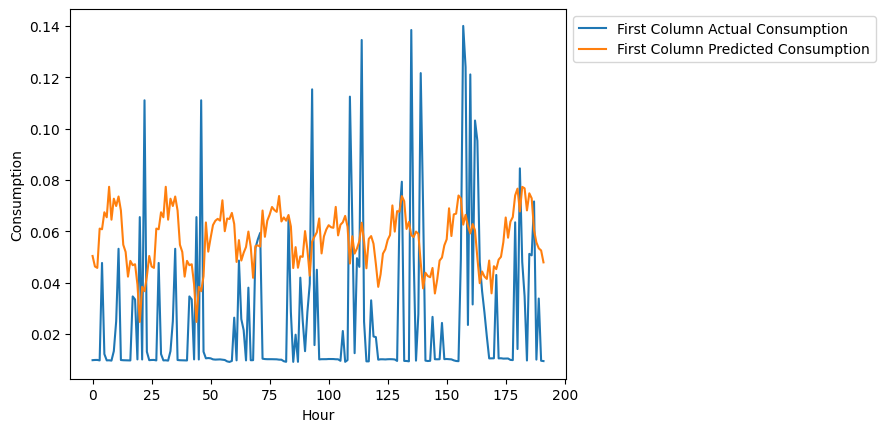

In [9]:
days_count = len(y_test) / 24
plot_predictions(int(days_count / 2), int(days_count / 2 + 7), y_test, best_prediction)